<a href="https://colab.research.google.com/github/rakakOB/IMS/blob/main/A_3308_Detectron2_Instance_3D_EM_Platelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/cEgF0YknpZw

## Train custom instance segmentation model using Detectron2 - on your own dataset

Create your own dataset by annotating for object detection using your favorite annotation software that can export annotations as COCO JSON format. I have used https://www.makesense.ai/ for my tutorial. I used the polygon tool to annotate objects and exported annotations as, "Single file in COCO JSON format"

**Install Detectron2**

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 16.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15860, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 15860 (delta 38), reused 15 (delta 13), pack-reused 15783 (from 3)
Receiving objects: 100% (15860/15860), 6.41 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (11541/11541), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The default models are trained on natural images so let us go ahead and load a natural image to see if detectron is working. **We will run a pre-trained model on this image.**

In [5]:
# import cv2
# from google.colab.patches import cv2_imshow

# # Load a test image from a URL
# !wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png -O test_image.png
# img = cv2.imread("test_image.png")
# cv2_imshow(img)  # Should work

In [6]:
import os

def print_directory_contents(path):
    """Prints all files and directories in the given path."""
    try:
        items = os.listdir(path)
        for item in items:
            print(item)
    except FileNotFoundError:
        print(f"Error: Directory '{path}' not found.")
    except PermissionError:
      print(f"Error: Permission denied to access '{path}'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Get the current working directory
current_directory = os.getcwd()
print("Current directory:")
print_directory_contents("/content/drive/MyDrive")

Current directory:
R6.pdf
janaru.v2i.yolov11.zip
ColabNotebooks
models
Image_detection.v2-2025-05-09-4-28pm.yolov11.zip


In [ ]:
# import os

# file_path = "/content/drive/MyDrive/f8.JPG"
# print(os.path.exists(file_path))  # Should output `True`

False


In [7]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/Image_detection.v2-2025-05-09-4-28pm.yolov11.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="/content/train16")

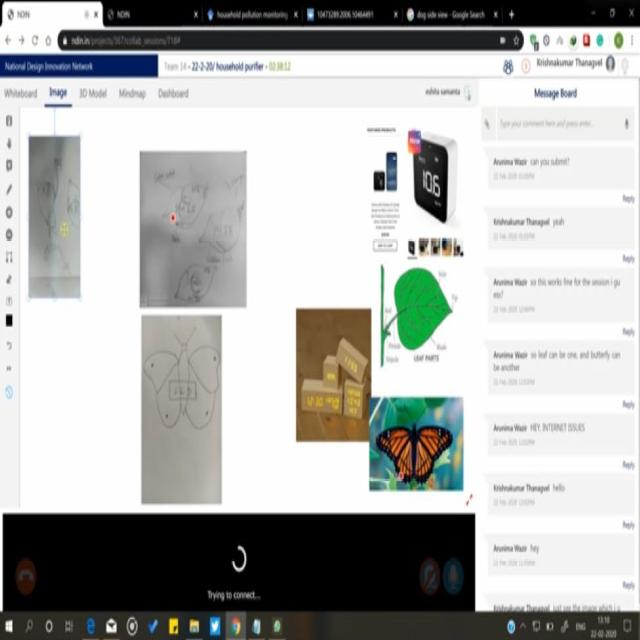

In [8]:
im = cv2.imread("/content/train16/valid/images/f16_png.rf.340ea6782ac027f398370424e8f72d4c.jpg")
cv2_imshow(im)

We create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[05/07 15:42:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0], device='cuda:0')
Boxes(tensor([[102.3744, 366.7838, 453.0699, 541.6201]], device='cuda:0'))


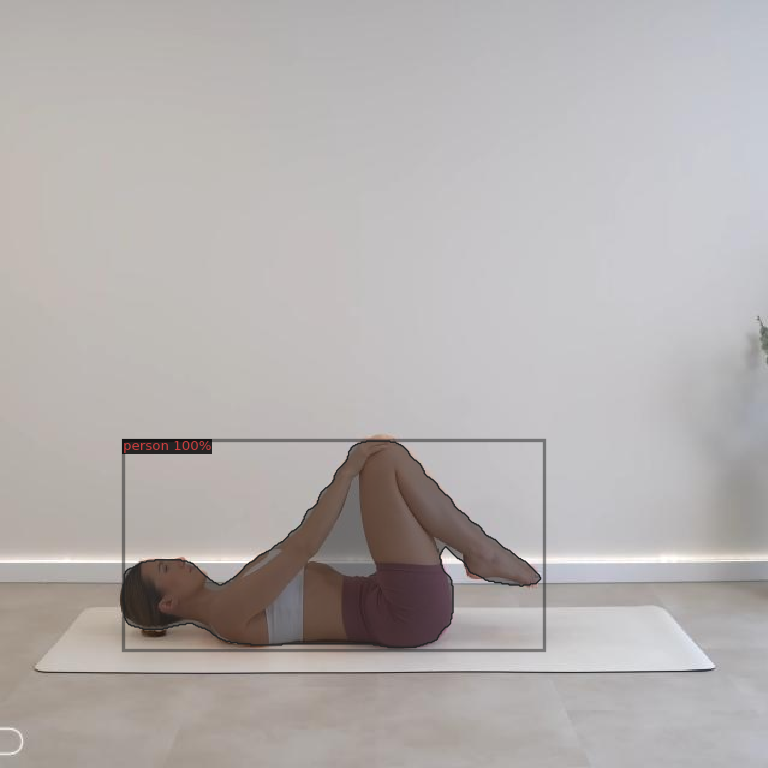

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Now that we know the model is working on a natural image, let us test on a scientific image.

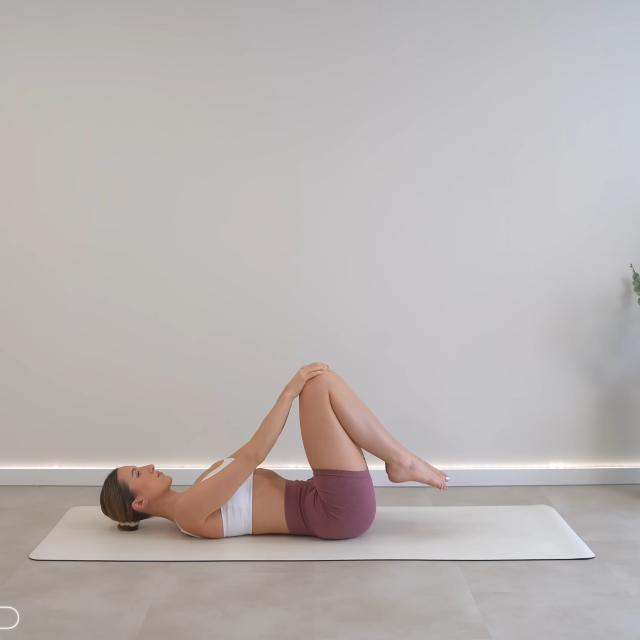

In [ ]:
sci_im = cv2.imread("/content/train16/test/images/rakesh2_frame_680_png.rf.d050fbababf1e4717f0ccdea7360308a.jpg")
cv2_imshow(sci_im)

Let us make some predictions. Remember that the model mask_rcnn_R_50_FPN_3x has no idea about our sample and did not get trained on cells or mitochondria or on any scientific images.

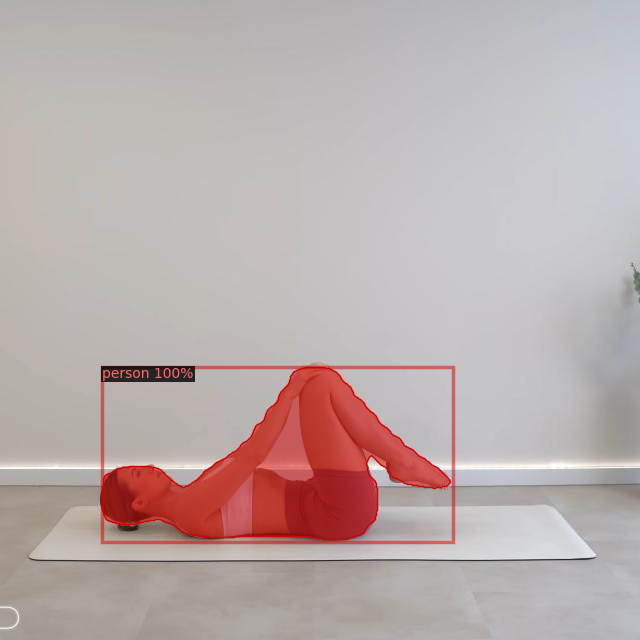

In [ ]:
sci_outputs = predictor(sci_im)
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

Of course, our cells are mislabeled as Tie, Pizza, etc. Let us train on a custom dataset.

# Train on a custom dataset

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the coco format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



In [ ]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "/content/runs/pose/train16/train/labels", "/content/runs/pose/train16/train/images")
# register_coco_instances("my_dataset_val", {}, "/content/runs/pose/train16/valid/labels", "/content/runs/pose/train16/valid/images")



Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [9]:
import os
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

def load_yolo_dataset(dataset_dir, annotations_dir, class_names):
    dataset_dicts = []
    for idx, image_file in enumerate(os.listdir(dataset_dir)):
        if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        record = {}
        image_path = os.path.join(dataset_dir, image_file)
        label_path = os.path.join(annotations_dir, os.path.splitext(image_file)[0] + '.txt')

        # Read image dimensions
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        record["file_name"] = image_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # Parse YOLO annotations
        objs = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])

                    # Convert normalized YOLO to absolute coordinates
                    x = (x_center - w/2) * width
                    y = (y_center - h/2) * height
                    w = w * width
                    h = h * height

                    obj = {
                        "bbox": [x, y, w, h],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [27]:
# Define paths
train_dir = "/content/train16/train/images"
train_annotations_dir = "/content/train16/train/labels"
val_dir = "/content/train16/valid/images"
val_annotations_dir = "/content/train16/valid/labels"

test_dir = "/content/train16/test/images"
test_annotations_dir = "/content/train16/test/labels"


# List your class names (order must match YOLO class IDs)
CLASS_NAMES = ['3b model', 'Document images', 'IGI', 'Sketch', 'chart and graphs']  # Replace with your classes

# Register datasets
DatasetCatalog.register("my_dataset_train2", lambda: load_yolo_dataset(train_dir, train_annotations_dir, CLASS_NAMES))
MetadataCatalog.get("my_dataset_train2").set(thing_classes=CLASS_NAMES)

DatasetCatalog.register("my_dataset_val2", lambda: load_yolo_dataset(val_dir, val_annotations_dir, CLASS_NAMES))
MetadataCatalog.get("my_dataset_val2").set(thing_classes=CLASS_NAMES)

DatasetCatalog.register("my_dataset_test2", lambda: load_yolo_dataset(test_dir, test_annotations_dir, CLASS_NAMES))
MetadataCatalog.get("my_dataset_test2").set(thing_classes=CLASS_NAMES)


namespace(name='my_dataset_test2', thing_classes=['ygi'])

In [28]:
train_metadata = MetadataCatalog.get("my_dataset_train2")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train2")

In [29]:
val_metadata = MetadataCatalog.get("my_dataset_val2")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val2")

test_metadata = MetadataCatalog.get("my_dataset_test2")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test2")


In [30]:
from matplotlib import pyplot as plt

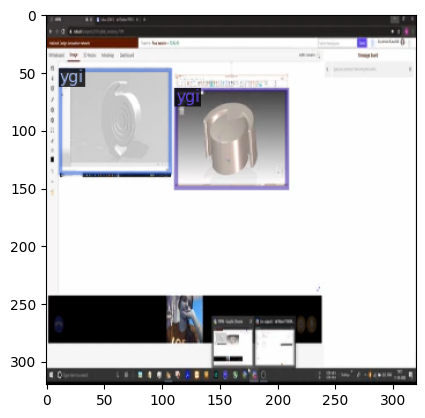

IndexError: list index out of range

In [36]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/models/Detectron2_Models"

# Change this line in your config:
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1400    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have [n...] classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[05/07 15:52:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 114MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


Train

In [ ]:
trainer.train() #Start the training process

[05/07 15:53:03 d2.engine.train_loop]: Starting training from iteration 0
[05/07 15:53:11 d2.utils.events]:  eta: 0:06:42  iter: 19  total_loss: 1.019  loss_cls: 0.6609  loss_box_reg: 0.3426  loss_rpn_cls: 0.001833  loss_rpn_loc: 0.004371    time: 0.2954  last_time: 0.3279  data_time: 0.0176  last_data_time: 0.0044   lr: 4.9953e-06  max_mem: 1913M
[05/07 15:53:22 d2.utils.events]:  eta: 0:06:43  iter: 39  total_loss: 0.9602  loss_cls: 0.5793  loss_box_reg: 0.3725  loss_rpn_cls: 0.001031  loss_rpn_loc: 0.004029    time: 0.3078  last_time: 0.2524  data_time: 0.0102  last_data_time: 0.0108   lr: 9.9902e-06  max_mem: 1914M
[05/07 15:53:28 d2.utils.events]:  eta: 0:06:44  iter: 59  total_loss: 0.7953  loss_cls: 0.4377  loss_box_reg: 0.3503  loss_rpn_cls: 0.004984  loss_rpn_loc: 0.004361    time: 0.3089  last_time: 0.3313  data_time: 0.0073  last_data_time: 0.0048   lr: 1.4985e-05  max_mem: 1914M
[05/07 15:53:34 d2.utils.events]:  eta: 0:06:41  iter: 79  total_loss: 0.6714  loss_cls: 0.327  

Save the config file, for potential future use

In [ ]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

In [ ]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/07 16:04:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/Detectron2_Models/model_final.pth ...


Verify segmentation on random validation images

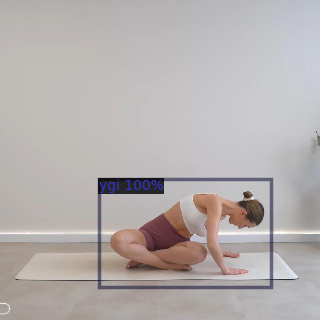

In [ ]:
# HERE.
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/07 16:05:36 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/07 16:05:36 d2.evaluation.coco_evaluation]: Trying to convert 'my_dataset_val' to COCO format ...
[05/07 16:05:36 d2.data.datasets.coco]: Converting annotations of dataset 'my_dataset_val' to COCO format ...)
[05/07 16:05:36 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/07 16:05:36 d2.data.datasets.coco]: Conversion finished, #images: 23, #annotations: 23
[05/07 16:05:36 d2.data.datasets.coco]: Caching COCO format annotations at './output/my_dataset_val_coco_format.json' ...
[05/07 16:05:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/07 16:05:36 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/07 16:05:36 d2.data.common]: Serializing 23 elements to byte tensors and conca

**Load a new image and segment it.**

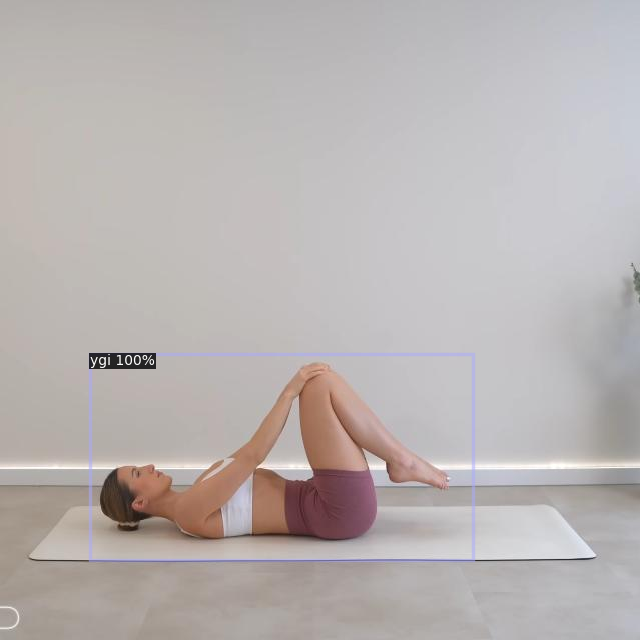

In [ ]:

# new_im = cv2.imread("/content/runs/pose/train16/test/images/rakesh2_frame_669_png.rf.2cdc96dfeb6bbc7752ae8362654e8b07.jpg")
# new_im = cv2.imread("/content/runs/pose/train16/test/images/rakesh_frame_455.png")
new_im = cv2.imread("/content/train16/test/images/rakesh2_frame_680_png.rf.d050fbababf1e4717f0ccdea7360308a.jpg")

outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])


**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/train16/test/images"

# Output directory where the segmented images will be saved
output_directory = "/content/detections"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


Segmentation of all images completed.



**Segment images and save object level information into a csv file.**




In [ ]:
import csv
import os
import cv2
from detectron2.data import MetadataCatalog

# Assuming you've already defined the 'predictor' and registered your dataset
# Make sure 'metadata' points to your training metadata (e.g., MetadataCatalog.get("my_dataset_train"))

input_images_directory = "/content/train16/test/images"
output_csv_path = "/content/drive/MyDrive/models/output_objects_00000.csv"

with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Update header to reflect detection-specific fields
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox", "Confidence"])

    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Get predictions
        outputs = predictor(new_im)
        instances = outputs["instances"]

        # Extract detection outputs
        boxes = instances.pred_boxes.tensor.cpu().numpy()  # (x1, y1, x2, y2)
        class_labels = instances.pred_classes.cpu().numpy()
        scores = instances.scores.cpu().numpy()  # Confidence scores

        for obj_idx in range(len(instances)):
            x1, y1, x2, y2 = boxes[obj_idx]

            # Calculate properties from bounding box
            area = (x2 - x1) * (y2 - y1)
            centroid = ((x1 + x2) / 2, (y1 + y2) / 2)
            bbox = (x1, y1, x2, y2)

            class_id = class_labels[obj_idx]
            class_name = metadata.thing_classes[class_id]
            confidence = scores[obj_idx]

            csvwriter.writerow([
                image_filename,
                class_name,
                obj_idx + 1,  # Object number
                area,
                centroid,
                bbox,
                confidence  # Added confidence score
            ])

print("Detection results saved to CSV.")


Detection results saved to CSV.


In [ ]:
import csv
import os
import cv2
from detectron2.structures import BoxMode

# Assuming you have already defined the 'predictor' object and loaded the detection model
# Make sure 'metadata' is properly defined (e.g. metadata = MetadataCatalog.get("my_dataset_train"))
metadata = MetadataCatalog.get("my_dataset_train")  # Define metadata here

input_images_directory = "/content/train16/test/images"
output_csv_path = "/content/drive/MyDrive/models/output_objects.csv"

with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Modified header for detection-only outputs
    csvwriter.writerow(["File Name", "Class Name", "Object Number",
                       "Area", "Centroid", "BoundingBox (XYXY)", "Confidence"])

    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)
        outputs = predictor(new_im)

        # Get detection outputs
        instances = outputs["instances"]

        # For detection-only models, use these fields:
        boxes = instances.pred_boxes.tensor.cpu().numpy()  # Get bounding boxes in XYXY format
        scores = instances.scores.cpu().numpy()  # Confidence scores
        class_labels = instances.pred_classes.cpu().numpy()  # Class IDs

        for i, (box, score, class_id) in enumerate(zip(boxes, scores, class_labels)):
            # Calculate geometric properties from bounding box
            x0, y0, x1, y1 = box
            width = x1 - x0
            height = y1 - y0
            area = width * height
            centroid = ((x0 + x1)/2, (y0 + y1)/2)

            # Get class name from metadata
            class_name = metadata.thing_classes[class_id]

            # Write to CSV
            csvwriter.writerow([
                image_filename,
                class_name,
                i+1,  # Object number
                area,
                centroid,
                (x0, y0, x1, y1),  # XYXY format
                f"{score:.2f}"  # Confidence score
            ])

print("Detection results saved to CSV file.")

Detection results saved to CSV file.


In [ ]:
# import csv
# from skimage.measure import regionprops, label


# # Assuming you have already defined the 'predictor' object and loaded the model.
# # Also, make sure 'metadata' is defined appropriately.

# # Directory path to the input images folder
# input_images_directory = "/content/train16/test/images"

# # Output directory where the CSV file will be saved
# output_csv_path = "/content/drive/MyDrive/models/output_objects.csv"  # Replace this with the path to your desired output CSV file

# # Open the CSV file for writing
# with open(output_csv_path, 'w', newline='') as csvfile:
#     csvwriter = csv.writer(csvfile)

#     # Write the header row in the CSV file
#     csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

#     # Loop over the images in the input folder
#     for image_filename in os.listdir(input_images_directory):
#         image_path = os.path.join(input_images_directory, image_filename)
#         new_im = cv2.imread(image_path)

#         # Perform prediction on the new image
#         outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

#         # Convert the predicted mask to a binary mask
#         mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

#         # Get the predicted class labels
#         class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

#         # Debugging: print class_labels and metadata.thing_classes
#         #print("Class Labels:", class_labels)
#         #print("Thing Classes:", train_metadata.thing_classes)

#         # Use skimage.measure.regionprops to calculate object parameters
#         labeled_mask = label(mask)
#         props = regionprops(labeled_mask)

#         # Write the object-level information to the CSV file
#         for i, prop in enumerate(props):
#             object_number = i + 1  # Object number starts from 1
#             area = prop.area
#             centroid = prop.centroid
#             bounding_box = prop.bbox

#             # Check if the corresponding class label exists
#             if i < len(class_labels):
#                 class_label = class_labels[i]
#                 class_name = train_metadata.thing_classes[class_label]
#             else:
#                 # If class label is not available (should not happen), use 'Unknown' as class name
#                 class_name = 'Unknown'

#             # Write the object-level information to the CSV file
#             csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

# print("Object-level information saved to CSV file.")


**Generate plots to understand the objects**

<ipython-input-64-c474ac170c7e>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


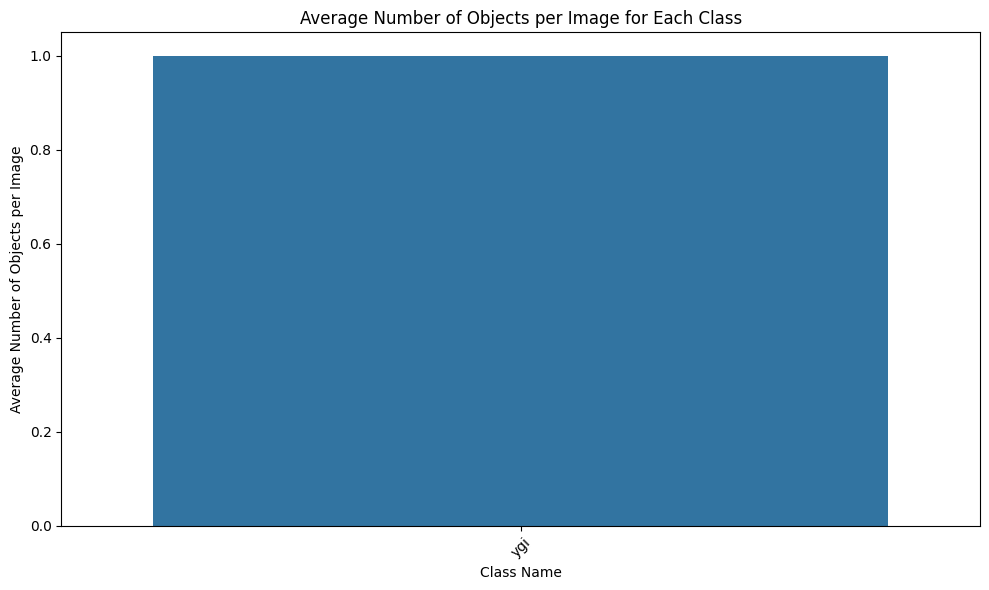

<ipython-input-64-c474ac170c7e>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)


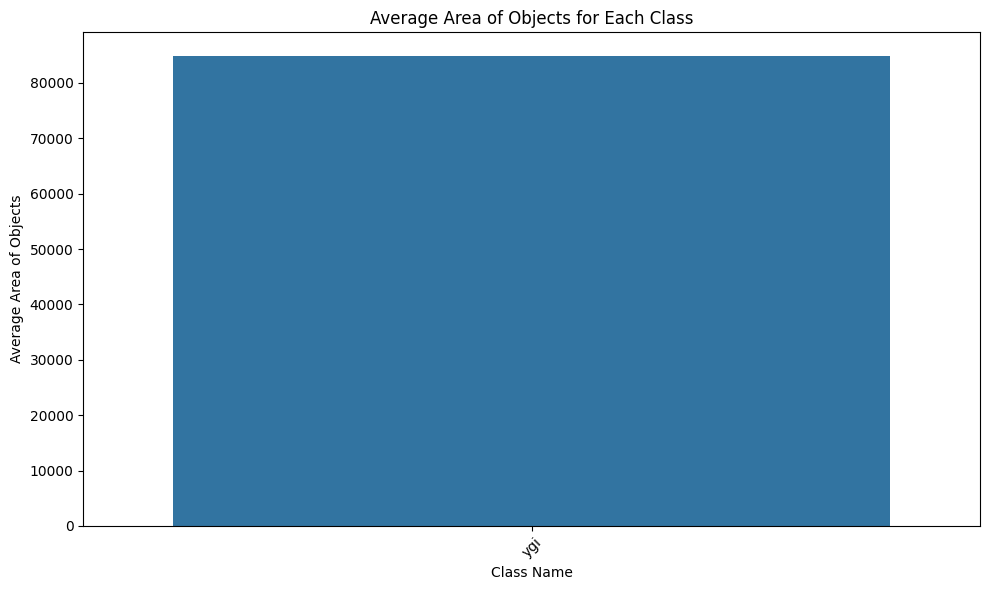

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "/content/drive/MyDrive/models/output_objects.csv"  # Update with your CSV file path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()




**Saving binary (actually multinary) images for each class for further processing.** Here, for each input image we will save n images corresponding to the number of classes. In our example, we will save 4 images for each image corresponding to the 4 classes. Each of these images will contain objects numbered 1, 2, 3, etc. - basically instance segmentation like images. These images can be used for further downstream processing.

In [ ]:
# import os
# import cv2
# import numpy as np
# import torch
# from detectron2.utils.visualizer import Visualizer

# # Directory path to the input images folder
# input_images_directory = "/content/train16/test/images"

# # Output directory where the segmented images will be saved
# output_directory = "/content/drive/MyDrive/models/test_results_instance"  # Replace this with the path to your desired output directory

# # Loop over the images in the input folder
# for image_filename in os.listdir(input_images_directory):
#     image_path = os.path.join(input_images_directory, image_filename)
#     new_im = cv2.imread(image_path)

#     # Perform prediction on the new image
#     outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

#     # Create a dictionary to store the mask for each class with unique integer labels
#     class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
#                    for class_name in train_metadata.thing_classes}

#     # Assign a unique integer label to each object in the mask
#     for i, pred_class in enumerate(outputs["instances"].pred_classes):
#         class_name = train_metadata.thing_classes[pred_class]
#         class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
#                                               i + 1,
#                                               class_masks[class_name])

#     # Save the masks for each class with unique integer labels
#     for class_name, class_mask in class_masks.items():
#         # Convert the tensor to a NumPy array and then to a regular (CPU) array
#         class_mask_np = class_mask.cpu().numpy()

#         # Create the output filename with _class_name_result.png extension
#         class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
#         class_output_path = os.path.join(output_directory, class_filename)

#         # Save the image with unique integer labels
#         cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

# print("Segmentation of all images completed.")


In [ ]:
import os
import cv2
from detectron2.utils.visualizer import Visualizer

# Directory paths
input_images_directory = "/content/train16/test/images"
output_directory = "/content/drive/MyDrive/models/test_results_instance"

# Create output directory if needed
os.makedirs(output_directory, exist_ok=True)

for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Get predictions
    outputs = predictor(new_im)
    instances = outputs["instances"].to("cpu")

    # Visualize predictions
    v = Visualizer(new_im[:, :, ::-1],
                   metadata=train_metadata,  # Make sure this is your actual metadata object
                   scale=1.0)
    out = v.draw_instance_predictions(instances)

    # Save visualized image
    output_path = os.path.join(output_directory, f"detected_{image_filename}")
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Detection visualization completed.")

Detection visualization completed.


In [ ]:
import os
import cv2
from detectron2.utils.visualizer import Visualizer

# Directory paths
input_images_directory = "/content/train16/test/images"
output_directory = "/content/drive/MyDrive/models/test_results_instance_2000001"

# Create output directory if needed
os.makedirs(output_directory, exist_ok=True)

for image_filename in os.listdir(input_images_directory):
    # image_path = os.path.join(input_images_directory, image_filename)
    # new_im = cv2.imread(image_path)

    # # Get predictions
    # outputs = predictor(new_im)
    # instances = outputs["instances"].to("cpu")

    # # Visualize predictions
    # v = Visualizer(new_im[:, :, ::-1],
    #                metadata=train_metadata,  # Make sure this is your actual metadata object
    #                scale=1.0)
    # out = v.draw_instance_predictions(instances)

    # # Save visualized image
    # output_path = os.path.join(output_directory, f"detected_{image_filename}")
    # cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

    # 0000000000000000000000000000

    instances = outputs["instances"].to("cpu")

    # Get class IDs from your metadata
    class_ids = {name: i for i, name in enumerate(train_metadata.thing_classes)}

    # Filter by class
    for class_name, class_id in class_ids.items():
        # Create mask for this class
        class_mask = instances.pred_classes == class_id
        class_instances = instances[class_mask]

        # Visualize only this class
        v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
        out = v.draw_instance_predictions(class_instances)

        # Save class-specific visualization
        class_output_path = os.path.join(output_directory, f"{image_filename[:-4]}_{class_name}.jpg")
        cv2.imwrite(class_output_path, out.get_image()[:, :, ::-1])

print("Detection visualization completed.")

Detection visualization completed.


# END

**Interested in panoptic segmentation?**

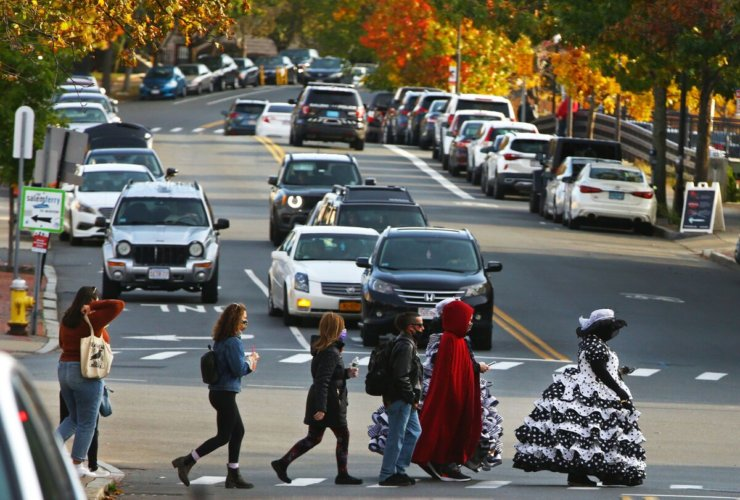

In [ ]:
my_new_image = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/street_small.jpg")
cv2_imshow(my_new_image)

[08/01 17:27:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


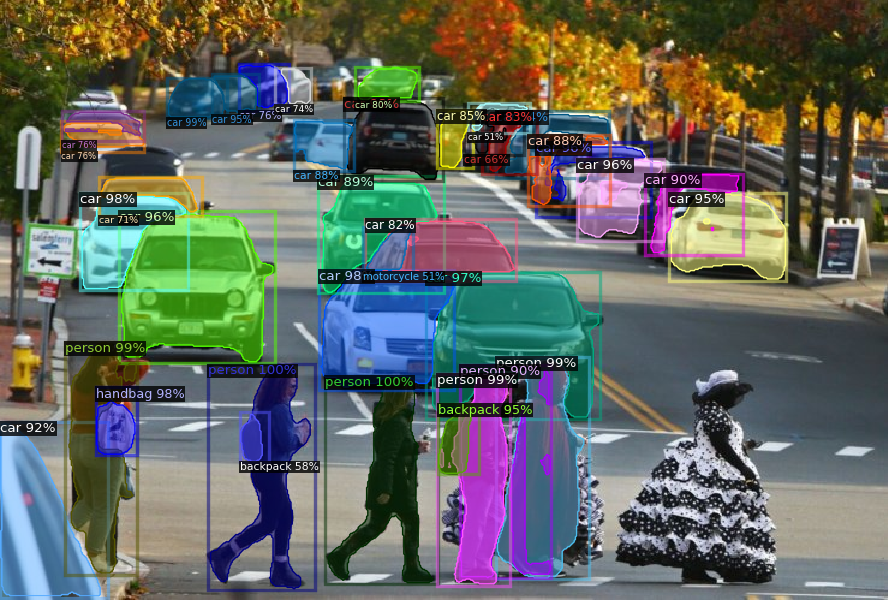

In [ ]:
# Inference with instance segmentation
cfg_inst = get_cfg()
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg_inst)
outputs = predictor(my_new_image)

v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Panoptic segmentation = Instance segmentation + Semantic Segmentation**





[08/01 17:27:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:03, 81.0MB/s]                          


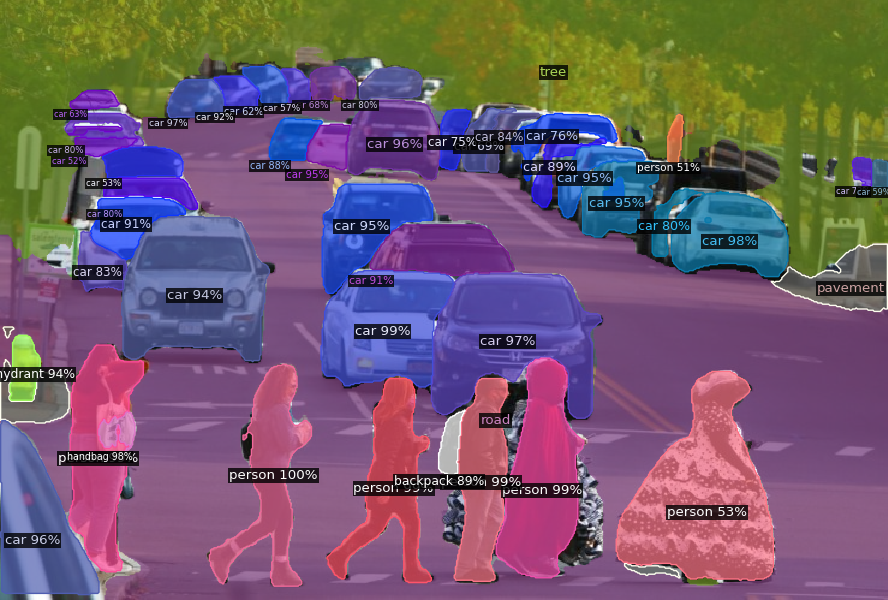

In [ ]:
# Inference with a panoptic segmentation model
cfg_pan = get_cfg()
cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_pan.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg_pan)
panoptic_seg, segments_info = predictor(my_new_image)["panoptic_seg"]
v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])